In [1]:
import sys
sys.path.insert(0, '../')
from functions import *

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
# Random Seed for dataset generation
sampling_seed = 15
torch.manual_seed(sampling_seed)

In [2]:
data = pd.read_table('TrainingData.txt', delimiter=' ', dtype='float', header=None)
data = np.array(data.iloc[:,:])

perc = 0
validation_size = int(perc*data.shape[0]/100)
training_size = data.shape[0] - validation_size
data_norm, data_train, data_val = [], [], []
for i in range(data.shape[1]):
    data_norm.append(data[:,i])
    data_train.append(data[:training_size,i])
    data_val.append(data[training_size:,i])

data_mean, data_std = [], []
for i in range(data.shape[1]):
    data_mean.append(data[:,i].mean())
    data_std.append(data[:,i].std())
    data_norm[i] = ((data_norm[i]-data_mean[i])/data_std[i]).reshape(-1,1)
    data_train[i] = ((data_train[i]-data_mean[i])/data_std[i]).reshape(-1,1)
    data_val[i] = ((data_val[i]-data_mean[i])/data_std[i]).reshape(-1,1)

In [3]:
data_norm[0] = ((data[:,0]-2)/18).reshape(-1,1)
data_norm[1] = ((data[:,1]-50)/350).reshape(-1,1)
data_norm[2] = (data[:,2]).reshape(-1,1)

batch_size = data_norm[0].shape[0]
retrain = 128
n_epochs_1 = 300
#training = DataLoader(torch.utils.data.TensorDataset(torch.stack([data_norm[0],data_norm[1]]).reshape(-1,2), data_norm[2]), batch_size=batch_size, shuffle=True)
training = DataLoader(torch.utils.data.TensorDataset(torch.tensor(np.concatenate((data_norm[0],data_norm[1]),axis=1)), torch.tensor(data_norm[2])), batch_size=batch_size, shuffle=True)
my_network_1 = NeuralNet_Seq(input_dimension=2, output_dimension=1, n_hidden_layers=4, neurons=20)
init_xavier(my_network_1, retrain + np.random.randint(-retrain,retrain))
optimizer = optim.LBFGS(my_network_1.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
if perc == 0:
    history = fit(my_network_1, training, n_epochs_1, optimizer, p=2, reg_param=0.0, verbose=False)
else:
    history = fit_k(my_network_1, training, torch.tensor(np.concatenate((data_val[0],data_val[1]),axis=1)).float(), torch.tensor(data_val[2]), n_epochs_1, optimizer, p=2, reg_param=0.0, verbose=False)

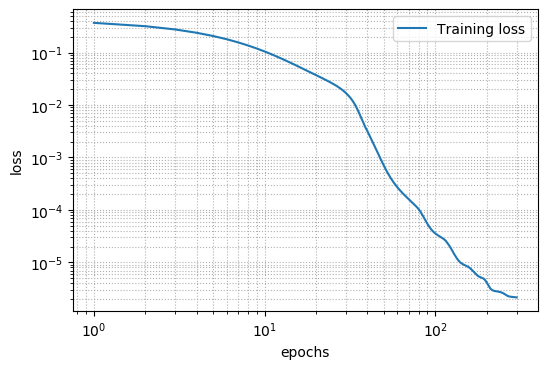

In [4]:
plt.figure()
plt.grid(True, which="both", ls=":")
if perc == 0:
    plt.plot(np.arange(1,n_epochs_1+1), history, label='Training loss')
else:
    plt.plot(np.arange(1,n_epochs_1+1), history[0], label='Training loss')
    plt.plot(np.arange(1,n_epochs_1+1), history[1], label='Validation loss')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


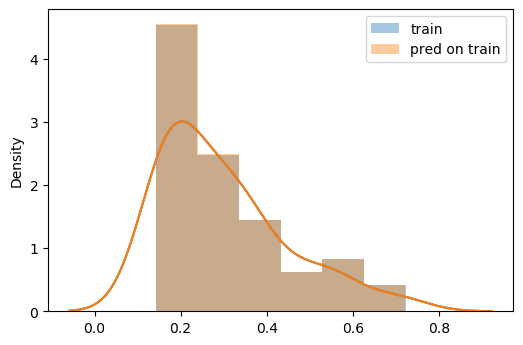

Relative Training Error:  0.44176009585189535 %


In [5]:
cf_train = my_network_1(torch.tensor(np.concatenate((data_norm[0],data_norm[1]),axis=1)).float()).reshape(-1,).detach()
#cf_train = cf_train*data_std[2] + data_mean[2]

plt.figure()
sns.distplot(data[:,2], label='train')
sns.distplot(cf_train, label='pred on train')
if perc != 0:
    sns.distplot(cf_val)
plt.legend()
plt.show()

relative_error_train = torch.mean((cf_train - torch.tensor(data[:,2]))**2)/torch.mean(torch.tensor(data[:,2])**2)
print("Relative Training Error: ", relative_error_train.detach().numpy()**0.5*100, "%")

if perc != 0:
    cf_val = my_network_1(torch.tensor(np.concatenate((data_val[0],data_val[1]),axis=1)).float()).reshape(-1,).detach()
    cf_val = cf_val*data_std[2] + data_mean[2]
    relative_error_train = torch.mean((cf_val - torch.tensor(data[training_size:,2]))**2)/torch.mean(torch.tensor(data[training_size:,2])**2)
    print("Relative Validation Error: ", relative_error_train.detach().numpy()**0.5*100, "%")

In [6]:
cf_ref = 0.45

def closure():
    G = (my_network_1(y_opt) - cf_ref) ** 2
    #print(G)
    cost[0] = G
    G.backward()
    return G

size = 20
minimizers = np.zeros((size,2),dtype='float')
i = 0
j = 0
while i < size:
    torch.manual_seed(j)
    y_opt = torch.rand(2, ).clone().detach().requires_grad_(True)
    #y_opt = (torch.rand(2, )-0.5).clone().detach().requires_grad_(True)
    y_init = torch.clone(y_opt)

    optimizer = optim.LBFGS([y_opt], lr=float(0.00001), max_iter=50000, max_eval=50000, history_size=100, line_search_fn="strong_wolfe",            tolerance_change=1.0 * np.finfo(float).eps)

    optimizer.zero_grad()
    cost = list([0])

    optimizer.step(closure=closure)
    
    if y_opt[0]< 0 or y_opt[0] > 1 or y_opt[1] < 0 or y_opt[1]> 1 or cost[0] > 1e-5:
    #if y_opt[0] < -0.5 or y_opt[0] > 0.5 or y_opt[1] < -0.5 or y_opt[1] > 0.5 or cost[0] > 1e-5:
        print('------------------------> CONTINUE <------------------------')
        j += 1
        continue

    print('---------------------- Minimizer ', i, ' ----------------------')
    print("Correspodning CF value: ", my_network_1(y_opt))
    #print("Correspodning CF value: ", my_network_1(y_opt)*data_std[2]+data_mean[2])
    y_opt = np.array(y_opt.detach())
    #minimizers[i] = np.array([y_opt[0], y_opt[1]])
    minimizers[i,:] = np.array([y_opt[0]*18+2, y_opt[1]*350+50])
    #print("Predicted minimizer", i, ": ", y_opt[0]*18+2, ', ', y_opt[1]*350+50)
    print("Predicted minimizer: ", y_opt[0], ', ', y_opt[1])
    #print("Predicted minimizer: ", minimizers[i])
    #print("Predicted minimizer: ", my_network_1(torch.stack([torch.tensor(minimizers[i,0]).float(),torch.tensor(minimizers[i,1]).float()]).reshape(-1,2)))
    print("Value of final cost function: ", cost[0].detach())

    i += 1
    j += 1

df = pd.DataFrame(minimizers)
df.to_csv('Task5_.txt', sep = ' ', header = False, index = None)

------------------------> CONTINUE <------------------------
---------------------- Minimizer  0  ----------------------
Correspodning CF value:  tensor([0.4500], grad_fn=<AddBackward0>)
Predicted minimizer:  0.7281088 ,  0.11964369
Value of final cost function:  tensor([8.8818e-16])
---------------------- Minimizer  1  ----------------------
Correspodning CF value:  tensor([0.4500], grad_fn=<AddBackward0>)
Predicted minimizer:  0.54495573 ,  0.15767805
Value of final cost function:  tensor([8.8818e-16])
---------------------- Minimizer  2  ----------------------
Correspodning CF value:  tensor([0.4500], grad_fn=<AddBackward0>)
Predicted minimizer:  0.024959259 ,  0.25819865
Value of final cost function:  tensor([8.8818e-16])
---------------------- Minimizer  3  ----------------------
Correspodning CF value:  tensor([0.4500], grad_fn=<AddBackward0>)
Predicted minimizer:  0.4708543 ,  0.17419283
Value of final cost function:  tensor([4.3521e-14])
---------------------- Minimizer  4  ---

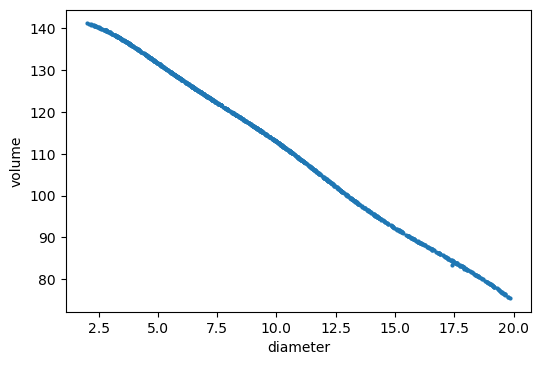

In [1]:
# Verification
import sys
sys.path.insert(0, '../')
from functions import *

mini = pd.read_table('Task5.txt', delimiter=' ', dtype='float', header=None)
mini = np.array(mini.iloc[:,:])
plt.scatter(mini[:,0],mini[:,1],s=4)
#plt.scatter(data[:,0],data[:,1],s=4)
plt.xlabel('diameter')
plt.ylabel('volume')
plt.show()

minimizers[:,0] = (minimizers[:,0]-2)/18
minimizers[:,1] = (minimizers[:,1]-50)/350
#ff1 = my_network_1(y_opt)
#print(minimizers)
#print(np.concatenate((minimizers[:,0].reshape(-1,1),minimizers[:,1].reshape(-1,1)),axis=1))
for i in range(minimizers.shape[0]):
    print(my_network_1(torch.tensor(np.array([minimizers[i,0],minimizers[i,1]])).float()))
print(my_network_1(torch.tensor(np.concatenate((minimizers[:,0].reshape(-1,1),minimizers[:,1].reshape(-1,1)),axis=1)).float()))
#print(ff1)
#print(np.abs(y_opt_det[1]-mini_norm[1][-1]))